In [1]:

import time
import os
import torch.nn.functional as F
import torch
import  torch.nn as nn
from collections import OrderedDict
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from utils import print_params_num, ImagePool, tensor2im, tensor2im_tanh
import draw
from dataFolder import vaeSRFolder
import models
from options import vaeSROption

loss_dict = {'mse':nn.MSELoss, 'l1':nn.L1Loss, 'bce':nn.BCELoss}
channel_of_colormode = {'L':1,'Y':1,'RGB':3}

In [ ]:
opt = vaeSROption()
randomblur_data = vaeSRFolder(opt)
randomblur_loader = DataLoader(randomblur_data, batch_size=1)
dataset_size = randomblur_data.__len__()
print("------------- loading dataset ---------------")
print("img num: %d" %(dataset_size) )
print("---------------------------------------------")
model = blindVAE(opt,isTrain=False,isSeperate=True,fromPretrain=True)
visualizer = draw.Visualizer(model.name())


model.set_input(data)
model.validate()

    total_steps = 0
    best_loss = None

    # seperate training
    if not frompretrain:
        print("-------------Seperate training---------------")
        for epoch in range(1, opt.niter + opt.niter_decay + 1):
            epoch_start_time = time.time()
            for i, data in enumerate(randomblur_loader):
                if len(data[0]) is not opt.batch_size:
                    continue
                iter_start_time = time.time()
                total_steps += opt.batch_size
                epoch_iter = total_steps - dataset_size * (epoch - 1)

                
                model.optimize_parameters()

                if total_steps % opt.interval_vis == 0:
                    visualizer.display_current_results(model.get_current_visuals())

                if total_steps % opt.interval_log == 0:
                    errors = model.get_current_errors()
                    t = (time.time() - iter_start_time) / opt.batch_size
                    visualizer.print_current_errors(epoch, epoch_iter, errors, t)
                    visualizer.plot_current_errors(epoch, float(epoch_iter) / dataset_size, errors)

                total_loss = model.get_total_loss()
                if best_loss is None:
                    best_loss = total_loss
                elif best_loss>total_loss:
                    best_loss = total_loss
                    model.save_network(epoch,total_steps,'best')

                if total_steps % opt.interval_save == 0:
                    model.save_network(epoch, total_steps,'train')


            print('End of epoch %d / %d \t Time Taken: %d sec' %
                  (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

            if epoch > opt.niter:
                model.update_learning_rate()

    if frompretrain:
        model.load_network(opt.seperate_model)
    print('--------------Combine training---------------')
    # conbime training
    model.old_lr = init_lr
    model.isSeperate = False
    for epoch in range(1, opt.niter + opt.niter_decay + 1):
        epoch_start_time = time.time()
        for i, data in enumerate(randomblur_loader):
            if len(data[0]) is not opt.batch_size:
                continue
            iter_start_time = time.time()
            total_steps += opt.batch_size
            epoch_iter = total_steps - dataset_size * (epoch - 1)

            model.set_input(data)
            model.optimize_parameters()

            if total_steps % opt.interval_vis == 0:
                visualizer.display_current_results(model.get_current_visuals())

            if total_steps % opt.interval_log == 0:
                errors = model.get_current_errors()
                t = (time.time() - iter_start_time) / opt.batch_size
                visualizer.print_current_errors(epoch, epoch_iter, errors, t)
                visualizer.plot_current_errors(epoch, float(epoch_iter) / dataset_size, errors)

            total_loss = model.get_total_loss()
            if best_loss is None:
                best_loss = total_loss
            elif best_loss>total_loss:
                best_loss = total_loss
                model.save_network(epoch,total_steps,'best')

            if total_steps % opt.interval_save == 0:
                model.save_network(epoch, total_steps,'train')


        print('End of epoch %d / %d \t Time Taken: %d sec' %
              (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

        if epoch > opt.niter:
            model.update_learning_rate()

In [554]:
import numpy
numpy.random.randint(8)
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


def psnr(im1, im2):
    MSE = mse(im1, im2)
    if MSE < 0.00000001:
        psnr = 10000
    else:
        psnr = 20 * np.log10(255) - 10 * np.log10(MSE)
    return psnr

In [141]:

from PIL import Image

import math
from torch.autograd import Variable
from torchvision import transforms

import os
import torch
from collections import OrderedDict
from torch.autograd import Variable
import numpy as np
from train_vaeSRnet import blindVAE
from options import vaeSROption
import utils
import filters

torch.cuda.set_device(1)
norm_flag = False
make_lr_flag = True

refdir = "/home/wcd/Projects/Pytorch-examples/fast_neural_style/images/banckmark/vae"
lrdir = "/home/wcd/Projects/Pytorch-examples/fast_neural_style/images/style-images/SR"

modelname = 'come18_st1440000_vaeSR_gauss_3.0_mang_89_mlen8_SRIN_block20_PBN_block8.model'
modeldir = os.path.join("/home/wcd/Projects/Pytorch-examples/fast_neural_style/neural_style/ckpt/tanh_out",modelname)

netdict = torch.load(modeldir)
opt = vaeSROption()
opt.seperate_model = modeldir
opt.batch_size = 1


net = blindVAE(opt,isTrain=False,isSeperate=False,fromPretrain=False)
net.load_network(modeldir)

------------ Networks initialized -------------
condition_SRNet (
  (resblocks): ModuleList (
    (0): ResidualBlock (
      (conv1): ConvLayer (
        (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
        (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (conv2): ConvLayer (
        (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
        (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (relu): ReLU ()
      (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
      (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False)
    )
    (1): ResidualBlock (
      (conv1): ConvLayer (
        (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
        (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (conv2): ConvLayer (
        (reflection_pad): ReflectionPad2d (1, 1, 1, 1)
        (conv2d): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (relu): ReLU ()
      (norm1): InstanceNorm2

In [94]:
net.netSR.encoder.convlist[0].conv2d.weight[:,0,:,:].data.cpu().numpy()

array([[[ 0.01551178, -0.0115744 ,  0.10395102, ...,  0.18855447,
          0.08463712, -0.00102442],
        [-0.00500598,  0.13350962, -0.09395262, ..., -0.05608478,
         -0.1832504 ,  0.03167845],
        [ 0.06892984, -0.06447008, -0.2090081 , ...,  0.14854956,
          0.19389962, -0.0856991 ],
        ..., 
        [ 0.04928026, -0.02597688, -0.08380998, ...,  0.27194226,
          0.05064091, -0.03276661],
        [-0.00795603, -0.02413358,  0.2168632 , ...,  0.1164324 ,
         -0.09900965,  0.03376618],
        [ 0.04158298,  0.02138946, -0.14130118, ...,  0.04152703,
          0.02203352, -0.16292059]],

       [[-0.02804441, -0.02918895, -0.03082312, ...,  0.09142242,
          0.0213835 , -0.03773291],
        [-0.02371525,  0.03420737,  0.02121974, ..., -0.01301038,
          0.01747206, -0.00289777],
        [-0.00849548, -0.06263974,  0.11643602, ...,  0.14365689,
          0.0974207 ,  0.0148859 ],
        ..., 
        [-0.08947537, -0.0333522 , -0.02150515, ...,

In [95]:
net.netSR.encoder.convlist[0].conv2d.weight[:,1,:,:].data.cpu().numpy()

array([[[  2.06827230e-04,  -8.81281868e-03,   7.81035889e-03, ...,
          -7.59951398e-03,  -8.93170200e-03,  -2.94431206e-02],
        [ -6.65654708e-03,   2.59028766e-02,   1.60456151e-02, ...,
          -1.70379877e-02,  -2.48035025e-02,  -2.89255520e-03],
        [  1.79056022e-02,   4.63518351e-02,   3.25127915e-02, ...,
          -9.11165122e-03,  -3.89389955e-02,   5.44316135e-03],
        ..., 
        [  1.35631505e-02,   3.03482190e-02,   1.65279843e-02, ...,
          -1.79941989e-02,  -2.38160267e-02,   2.30608415e-02],
        [  3.36648673e-02,   3.58114280e-02,   1.34325037e-02, ...,
          -1.67244710e-02,  -2.22257394e-02,   1.47451488e-02],
        [  5.43346442e-03,   2.65633743e-02,  -3.63856298e-03, ...,
          -3.67013924e-02,  -1.50163285e-02,  -1.64454728e-02]],

       [[  4.63453345e-02,   2.29856130e-02,  -1.54053951e-02, ...,
          -1.02003925e-02,  -9.34837665e-03,  -2.26059780e-02],
        [  2.05259845e-02,  -1.37726208e-02,   1.44609949e-0

In [91]:
net.netSR.encoder.convlist[0].conv2d.weight[:,2,:,:].data.cpu().numpy()

array([[[  6.28093407e-02,  -3.57452244e-03,  -3.04995924e-02, ...,
          -1.20888231e-02,   5.98938949e-02,   5.04118800e-02],
        [ -2.63705570e-02,  -3.64651382e-02,   4.25384715e-02, ...,
          -9.48379515e-04,   6.41223118e-02,   5.58843021e-04],
        [ -4.48978245e-02,   1.57899298e-02,   4.15415727e-02, ...,
           7.55127519e-03,  -2.05911603e-02,   5.19620329e-02],
        ..., 
        [ -2.34153140e-02,   4.86790314e-02,   5.17698638e-02, ...,
           6.22867979e-03,   5.36350980e-02,   4.50694114e-02],
        [  9.29817837e-03,   5.21375649e-02,  -9.17368475e-03, ...,
           3.06093469e-02,   1.18371937e-02,   6.21156842e-02],
        [ -3.02950274e-02,  -1.35025429e-02,  -1.16828755e-02, ...,
          -2.65704170e-02,  -5.98452473e-03,   2.58205999e-02]],

       [[ -2.22349931e-02,  -7.30165374e-03,   2.68329754e-02, ...,
          -1.64709184e-02,   2.27477476e-02,   4.54317182e-02],
        [  4.54869680e-02,   4.65757288e-02,  -4.49673422e-0

In [96]:
net.netSR.encoder.convlist[0].conv2d.weight[:,3,:,:].data.cpu().numpy()

array([[[ -1.34216696e-01,   1.22842021e-01,   1.10940747e-01, ...,
           1.09586582e-01,   4.14975360e-02,  -9.77809057e-02],
        [  7.10724015e-03,  -8.79884139e-02,   2.90787444e-02, ...,
           7.28311157e-03,   8.21381360e-02,  -5.34751527e-02],
        [  9.10527632e-02,  -5.91881461e-02,  -1.15079857e-01, ...,
          -1.36033684e-01,  -1.03058346e-01,   1.19702742e-01],
        ..., 
        [  8.04317519e-02,  -1.22849517e-01,  -3.54117230e-02, ...,
          -1.06309779e-01,   1.02300951e-02,   1.23012036e-01],
        [  1.53020009e-01,   2.41777040e-02,  -1.67615280e-01, ...,
          -1.77807376e-01,  -1.19836062e-01,   8.60096589e-02],
        [ -8.82950872e-02,   1.53045684e-01,   9.77793485e-02, ...,
           7.95435682e-02,  -6.62148744e-02,  -1.29040018e-01]],

       [[ -4.20856252e-02,  -1.24879228e-02,  -5.05501404e-02, ...,
          -6.73275813e-02,  -8.68846625e-02,   4.67486456e-02],
        [ -5.43063395e-02,  -3.37683745e-02,   2.58847233e-0

In [606]:
#test for seperate gauss blur
origimg = Image.open("/home/wcd/Desktop/to_fast_neural_style/images/banckmark/vae/HR/pepper.bmp") 
nporigimg = np.array(origimg)
w = nporigimg.shape[1]
h = nporigimg.shape[0]
[w,h]

[512, 512]

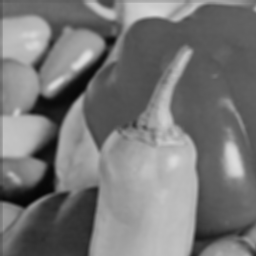

In [612]:
blurorigimglu = utils.HR2LR(origimg,gauss=2)
blurorigimglu = Image.fromarray(np.array(blurorigimglu)[:h//2,:w//2])
blurorigimglu

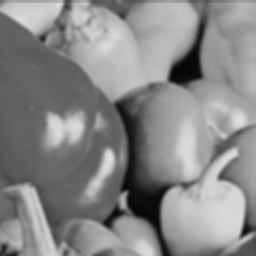

In [593]:
blurorigimgru = utils.HR2LR(origimg,gauss=3)
blurorigimgru = Image.fromarray(np.array(blurorigimgru)[:h//2,w//2:])
blurorigimgru

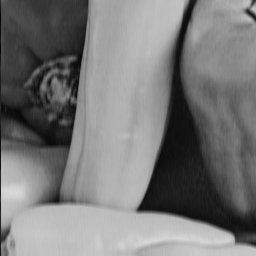

In [594]:
kernel,motion_anchor = filters.motion_kernel(length=8,angle=89)
blurorigimgld = utils.HR2LR(origimg,motion_anchor=motion_anchor,motion_kernel=kernel)
#blurorigimgld = utils.HR2LR(origimg,gauss=2.3)
blurorigimgld = Image.fromarray(np.array(blurorigimgld)[h//2:,:w//2])
blurorigimgld

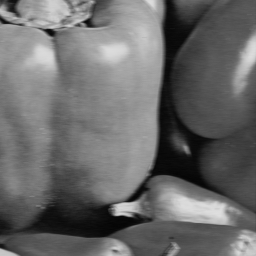

In [595]:
kernel,motion_anchor = filters.motion_kernel(length=8,angle=1)
blurorigimgrd = utils.HR2LR(origimg,motion_anchor=motion_anchor,motion_kernel=kernel)
#blurorigimgrd = utils.HR2LR(origimg,gauss=2.5)
blurorigimgrd = Image.fromarray(np.array(blurorigimgrd)[h//2:,w//2:])
blurorigimgrd

In [378]:
def stackimg(lu,ru,ld,rd):
    blur = np.vstack(
        (np.hstack((np.array(lu),np.array(ru))),
         np.hstack((np.array(ld),np.array(rd)))
        ))
    return Image.fromarray(blur)

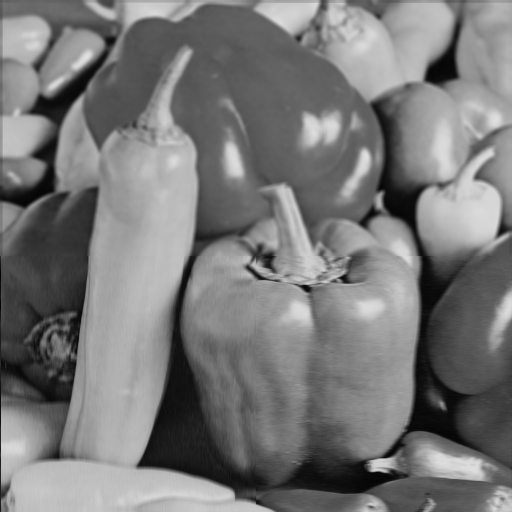

In [596]:
blurIMG = stackimg(blurorigimglu,blurorigimgru,blurorigimgld,blurorigimgrd)
blurIMG

In [545]:
up1down2blur = blurIMG

In [192]:
# input=>tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])
ptensor=torch.from_numpy(np.array([0,0,0]).astype(np.float32)).unsqueeze(0)


In [214]:
def input1img(net,blurIMG):
    lrtensor = transform(blurIMG).unsqueeze(0)
    lrtensor = (lrtensor-0.5)/0.5
    hrtensor = lrtensor.clone()
    net.set_input([hrtensor,lrtensor,ptensor])
    net.validate()
    sr = net.SR
    sr = sr.cpu().data.squeeze(0).clamp(-1,1)
    sr = (sr+1)/2.0 *255.0
    srIMG = sr.squeeze(0).clone().clamp(0, 255).numpy().astype("uint8")
    srIMG = Image.fromarray(srIMG, 'L')
    #
    return srIMG

In [613]:
lrud1223_sr = input1img(net,blurorigimglu)

In [587]:
lrud1223_sep_sr = stackimg(
    input1img(net,blurorigimglu),input1img(net,blurorigimgru),input1img(net,blurorigimgld),input1img(net,blurorigimgrd)
)

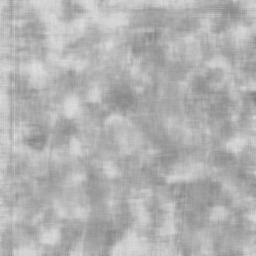

In [614]:
pmap = net.fake_p[0][0][:][:].data.cpu()
pmap = pmap.clamp(0,1)
pmap = pmap*255.0
pmapIMG = pmap.clamp(0, 255).numpy().astype("uint8")
Image.fromarray(pmapIMG, 'L')

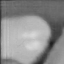

In [611]:
lrud1223_sr

In [604]:
print("psnr inc")
psnr(np.array(lrud1223_sr),nporigimg)-psnr(np.array(blurIMG),nporigimg)

psnr inc


-0.080584816024174444

In [603]:
print("psnr inc")
psnr(np.array(lrud1223_sep_sr),nporigimg)-psnr(np.array(blurIMG),nporigimg)

psnr inc


7.8616636660862014

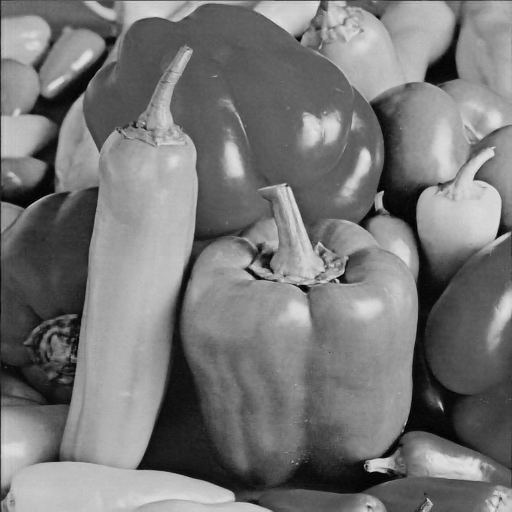

In [602]:
lrud1223_sep_sr

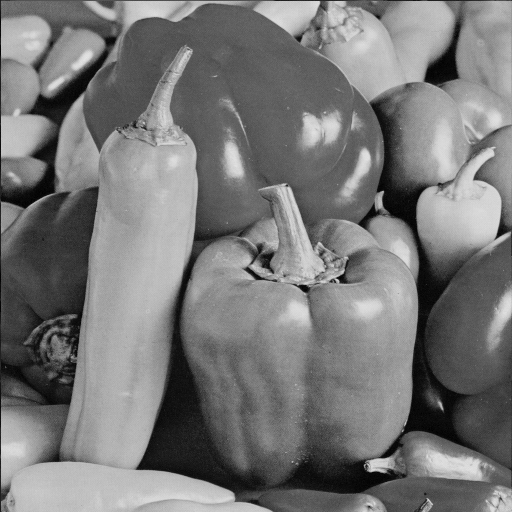

In [605]:
origimg

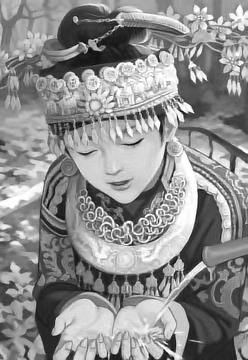

In [222]:
lrud2_1to2_4sep_sr

In [520]:
idx = '0000574'
origtext = Image.open('/home/wcd/LinkToMyLib/Datas/BMVC_large_patches/'+idx+'_orig.png').convert('L')
blurtext = Image.open('/home/wcd/LinkToMyLib/Datas/BMVC_large_patches/'+idx+'_blur.png').convert('L')
kertext = Image.open('/home/wcd/LinkToMyLib/Datas/BMVC_large_patches/'+idx+'_psf.png').convert('L')

In [521]:
kertext

In [522]:
srtext = input1img(net,blurtext)

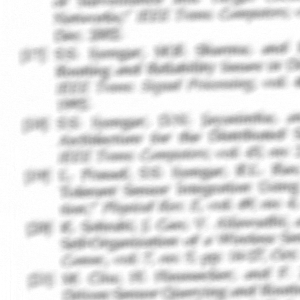

In [523]:
srtext

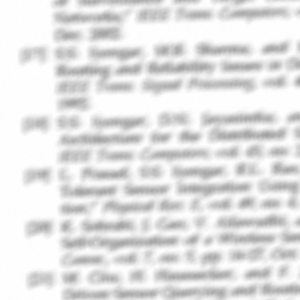

In [524]:
blurtext

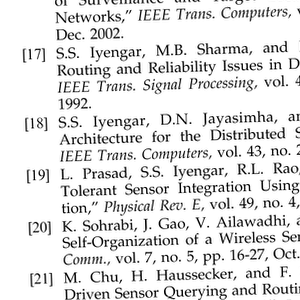

In [525]:
origtext